<a href="https://colab.research.google.com/github/Razvi103/Poem-Generation-with-LSTMs/blob/main/Poem_Generator_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GlobalMaxPooling1D, Embedding, Dropout
from tensorflow.keras.models import Model


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

train_csv = pd.read_csv("Poem_classification - train_data.csv")
test_csv = pd.read_csv("Poem_classification - test_data.csv")

print(train_csv.head())
print(test_csv.head())

# Clean the text data by removing unicode '\xa0 and hyphens from the Poem columns
train_csv['Poem'] = train_csv['Poem'].str.replace(r'\b-\w+', '', regex=True).str.replace(r'\b\w+-\w+\b', ' ', regex=True).str.replace('\xa0', ' ').str.strip()
test_csv['Poem'] = test_csv['Poem'].str.replace(r'\b-\w+', '', regex=True).str.replace(r'\b\w+-\w+\b', ' ', regex=True).str.replace('\xa0', ' ').str.strip()

# we only need the poem columns from the dataset because we are not doing classification
train_data = train_csv.iloc[1:, 1:].values
train_data_2 = test_csv.iloc[1:, 1:].values


   Genre                                               Poem
0  Music                                                NaN
1  Music                In the thick brushthey spend the...
2  Music     Storms are generous.                       ...
3  Music   —After Ana Mendieta Did you carry around the ...
4  Music   for Aja Sherrard at 20The portent may itself ...
   Genre                                               Poem
0  Music  A woman walks by the bench I’m sitting onwith ...
1  Music  Because I am a boy, the untouchability of beau...
2  Music  Because today we did not leave this world,We n...
3  Music  Big Bend has been here, been here. Shouldn’t i...
4  Music  I put shells there, along the lip of the road....


In [5]:
import numpy as np
# Combine train and test datasets from kaggle and reshape it
train_data_combined = np.vstack((train_data, train_data_2))
train_data_combined = train_data_combined.reshape(-1)



# a list of all the indexes where floats are located
float_indexes = []
max_len = 0
for i in range(len(train_data_combined)):
  if not isinstance(train_data_combined[i], str):
    float_indexes.append(i)
  else:
    train_data_combined[i] = train_data_combined[i].lower()
    # count the maximum number of words in a poem
    if len(train_data_combined[i]) > max_len:
      max_len = len(train_data_combined[i])

# remove all the floats that are not part of a string
train_data_combined = np.delete(train_data_combined, float_indexes)
print(max_len)


437


In [6]:
# initialize tokenizer, fit on text and tokenize the sequences
MAX_VOCAB_LENGTH = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB_LENGTH)
tokenizer.fit_on_texts(train_data_combined)
sequences = tokenizer.texts_to_sequences(train_data_combined)

In [7]:
# get the vocabulary length
vocabulary_length = len(tokenizer.word_index)
print(vocabulary_length)

SEQ_LENGTH = 40

# transform the tokenized sequences such that we have sequantial data
X_seq = []
y_seq = []
for poem in sequences:
  for i in range(len(poem) - SEQ_LENGTH):
    # append every SEQ_LENGTH words to X_seq and SEQ_LENGTH + 1 th word to y_seq
    X_seq.append(poem[i : i + SEQ_LENGTH])
    y_seq.append(poem[i + SEQ_LENGTH ])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)


print(X_seq.shape, y_seq.shape)



9628
(10646, 40) (10646,)


In [8]:
# input for a timeseries where data is stored as N x T x D is of shape T X D
# N - num of records
# T - sequence length
# D = num of features, (in our case 1)
inputs = Input(shape=(SEQ_LENGTH, ))

# embedding layer with dimension 150 for our 10000 words vocabulary
x = Embedding(vocabulary_length + 1, 150)(inputs)

# two LSTM layers with Droupout layers in between for regularization
x = LSTM(512, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(512, return_sequences=False)(x)
x = Dropout(0.2)(x)

# One Dense layer for complexity

x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

# final Dense layer for predicting the next word in the sequence,
# vocab_length + 1 units because tokenizer starts indexing from 1, we have a class for each word

outputs = Dense(vocabulary_length + 1, activation='softmax')(x)

# instantiate the model
model = Model(inputs, outputs)

In [9]:
# define a custom perplexity function
# perplexity is a better metric for text generation
def perplexity(y_true, y_pred):
    # convert y_pred to probabilities
    # clip to avoid log(0) errors
    y_pred = tf.clip_by_value(y_pred, 1e-10, 1.0)
    cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
    perplexity_value = tf.exp(tf.reduce_mean(cross_entropy))
    return perplexity_value


In [10]:
# compile the model using the rmsprop optimizer, which is generally good for rnn's
# loss is sparse_categorical_crossentropy because we are doing multi-label classification
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=[perplexity, 'accuracy'])

In [11]:
r = model.fit(X_seq, y_seq, epochs=200)

Epoch 1/200
333/333 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.0557 - loss: 7.7925 - perplexity: 3309.1140
Epoch 2/200
333/333 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.0634 - loss: 7.3086 - perplexity: 1631.7969
Epoch 3/200
333/333 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.0590 - loss: 7.2422 - perplexity: 1545.3173
Epoch 4/200
333/333 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.0673 - loss: 7.1593 - perplexity: 1455.1844
Epoch 5/200
333/333 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.0635 - loss: 7.1336 - perplexity: 1385.1991
Epoch 6/200
333/333 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.0656 - loss: 7.0927 - perplexity: 1358.9449
Epoch 7/200
333/333 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0668 - loss: 7.1089 - perplexity: 1376.6846
Epoch 8/200
333/333 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.0642 - loss: 7.0856 - perplexity: 1330.4280
Epoch 9/200
333/333 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.0696 - loss: 7.0168 - perplexi

In [12]:
# save the model to a h5 file
model.save('poet_model_v4.h5')

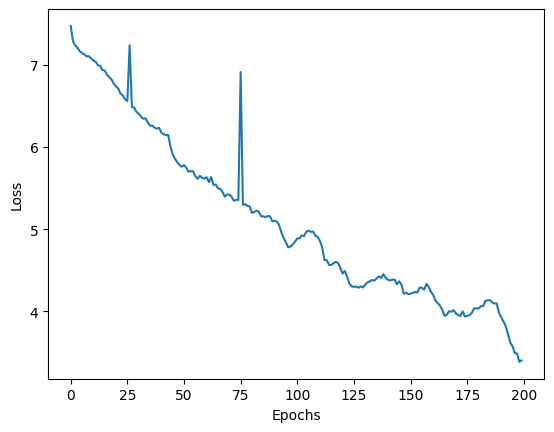

In [13]:
# plot the loss per epochs graph
plt.plot(r.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [14]:
# print the summary of the model
r.model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 40, 150)             │       1,444,350 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 40, 512)             │       1,357,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 512)                 │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9629)                │       4,939,677 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,207,416 (77.09 MB)

 Trainable params: 10,103,707 (38.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,103,709 (38.54 MB)

In [15]:
# helper function to generate poems based on a seed
def generate_poem(seed_text, num_of_words):
    poem = seed_text

    for i in range(num_of_words):
        # convert seed_text to sequences
        sequences = tokenizer.texts_to_sequences([seed_text])
        # pad sequences such that all sequences are of length SEQ_LENGTH
        padded_sequences = pad_sequences(sequences, maxlen=SEQ_LENGTH, truncating='pre')

        # predict the next word
        prediction = model.predict(padded_sequences)
        # get the index of the highest probability
        predicted_word_index = np.argmax(prediction, axis=-1)[0]
        # convert it back to a word
        predicted_word = tokenizer.index_word[predicted_word_index]

        # append predicted word to the poem
        poem += ' ' + predicted_word

        # update seed_text for the next prediction
        seed_text = ' '.join(seed_text.split()[1:] + [predicted_word])

    return poem




In [16]:
# load the model from the file
from tensorflow.keras.models import load_model

model = load_model('poet_model_v4.h5')

In [21]:
# generate from a random sequence from training
import random
seed = random.choice(X_seq)
seed = [tokenizer.index_word[token] for token in seed]
seed_text = ' '.join(seed)

print(seed_text)

print(generate_poem(seed_text, 30))


with the splendour of love's praise the pain the calm and the astonishment desire illimitable and still content and all dear names men use to cheat despair for the perplexed and viewless streams that bear our hearts at random down
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━

In [22]:
# generate from a string
seed = "Beneath the canopy of stars, a quiet world sleeps, where dreams are woven in the shadows of ancient trees."
print(generate_poem(seed, 20))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Beneath the canopy of stars, a quiet world sleeps, where dreams are woven in the shadows of ancient trees. through the stars who gloriously bright through any on roadsmake after him collapses all for its new on the fallen
